In [1]:
#from game import *
#import brick

In [2]:
from collections import namedtuple
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
import numpy as np
from itertools import count
import random
import math
import time
import matplotlib.pyplot as plt
from bomb import Bomb
import copy

### ALL THE VARIABLES

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
action_space = ('up', 'down', 'left', 'right', 'put', 'not')
prev_action = 'not'

In [5]:
survive_time_player_1 = []
survive_time_player_4 = []
reward_every_round_player_1 = []
reward_every_round_player_4 = []

In [6]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

In [7]:
all_symbol_in_game = (' ', 'X', '%', 'P', '0', '1', '2', 'e', 'B', 'Q')

In [8]:
BATCH_SIZE = 256
GAMMA = 0.99
EPS_START = 0.8
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 3

In [9]:
maximum_round = 1000

### ALL THE VARIABLES

In [10]:
import sys
from board import *
from gameConfig import *
import gameConfig
from bomberman import *
from getch import *
import bomb
#from bomb import bomb_plant1
#from bomb import bomb_plant2
#from bomb import bomb_plant3
#from bomb import bomb_plant4
import brick
import os
import time
import random
from algorithms import random_move
from IPython.display import clear_output

In [11]:
class Game:
    def __init__(self, level):
        self.level = level

Game_obj = Game(gameConfig.level)
#count_game_running = 1 #check if the game is working
tr = 0
tr2 = 0
brick_obj = brick.Brick(Game_obj)

In [12]:
obj1 = Bomberman(2, 2, 0, 3, global_arr, ar1)
obj4 = Bomberman(38, 74, 0, 3, global_arr, ar4)
bomb_plant1 = Bomb(obj1.x, obj1.y, obj1)
bomb_plant4 = Bomb(obj4.x, obj4.y, obj4)

In [13]:
init_screen = None
screen_height = None
screen_width = None
n_actions = len(action_space)

In [14]:
cur_round_count = 0

In [15]:
ocuupied_block = ('X', '%','0', '1', '2', 'B', 'P', 'Q')

In [16]:
def str_arr_to_float_arr(arr):
    #2d arr
    
    for x in range(len(arr)):
        for y in range(len(arr[0])):
            if arr[x][y] not in all_symbol_in_game:
                #print('not found in symbol list', arr[x][y])
                a = 0
            else:
                arr[x][y] = float(all_symbol_in_game.index(arr[x][y]))
    
    #state = torch.cat([state, state, state])
    #state.reshape(3, 42, 80)
    arr = np.array(arr)
    arr = torch.from_numpy(arr)
    arr2 = torch.empty(1, 1, 42, 80)
    arr2[0] = arr
    arr2 = arr2.to(device)
    #arr = arr.to(device)
    #arr = torch.cat([arr, arr, arr])
    #arr = arr.view(3, 42, 80)
    #arr = arr.view(3, 3, 3)
    return arr2

In [17]:
if init_screen == None:
    bp.make_board()
    test_arr = global_arr.copy()
    test_arr = str_arr_to_float_arr(test_arr)

if screen_height == None:
    screen_height = len(test_arr)
    
if screen_width == None:
    screen_width = len(test_arr[0])

screen_height, screen_width

(1, 1)

### NN MODEL

In [18]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [19]:
class DQN(nn.Module):

    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()
            
        #42*80
        self.conv1 = nn.Conv2d(1, 32, (8, 12), (2, 4), 0)
        #18*18
        self.conv2 = nn.Conv2d(32, 64, 6, 2, 0)
        #7*7
        self.conv3 = nn.Conv2d(64, 64, 3, 2, 0)
        #3*3
        '''
        #42*80
        self.conv1 = nn.Conv2d(1, 32, (6, 8), (2, 3), 0)
        #19*25
        #self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 5, 2, 0)
        #8*11
        self.conv3 = nn.Conv2d(64, 64, 3, 2, 0)
        #3 5
        
        #self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, 1, 0)
        #*23>12*11
        #self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, 3, 1, 0)
        #10*9>5*4
        '''
        
        
        #self.conv1 = nn.Conv2d(1, 32, 12, 4, 0)
        
        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        
        #print(linear_input_size)
        linear_input_size = 3*3*64 #576
        self.fc1 = nn.Linear(linear_input_size, linear_input_size//4)
        self.fc2 = nn.Linear(linear_input_size//4, linear_input_size//16)
        self.fc3 = nn.Linear(linear_input_size//16, outputs)
        #self.fc4 = nn.Linear(linear_input_size//8, outputs)
    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        #x = F.max_pool2d(F.relu(self.conv4(x)),2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        #x = F.relu(self.fc3(x))
        x = self.fc3(x)
        return x

In [20]:
def optimize_model(memory, policy_net, target_net, optimizer):
    #global memory_player1, memory_player4
    
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool).to(device)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # 1. Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    #    columns of actions taken. These are the actions which would've been taken
    #    for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # 2. Compute V(s_{t+1}) for all next states.
    #    Expected values of actions for non_final_next_states are computed based
    #    on the "older" target_net; selecting their best reward with max(1)[0].
    #    This is merged based on the mask, such that we'll have either the expected
    #    state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()

    # 3. Compute the expected Q values
    # 4. Compute Huber loss
  
    ### BEGIN SOLUTION
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
    ### END SOLUTION

    # 5. Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [21]:
policy_net = DQN(screen_height, screen_width, n_actions).to(device)
policy_net2 = DQN(screen_height, screen_width, n_actions).to(device)
target_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net2 = DQN(screen_height, screen_width, n_actions).to(device)

#policy_net = torch.load('./model/policy_net_20230103_21_14_40_episode500').to(device)
#target_net = torch.load('./model/target_net_20230103_21_14_40_episode500').to(device)


target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
target_net2.load_state_dict(policy_net2.state_dict())
target_net2.eval()

optimizer = optim.RMSprop(policy_net.parameters())
optimizer2 = optim.RMSprop(policy_net2.parameters())

#memory = ReplayMemory(20000)
memory_player1 = ReplayMemory(20000)
memory_player4 = ReplayMemory(20000)

steps_done = 0

In [22]:
def numpy_lr_up(tensor_arr):
    #input is torch.tensor
    tensor_arr = torch.fliplr(tensor_arr)
    tensor_arr = torch.flipud(tensor_arr).to(device)
    
    return tensor_arr

### GAME

In [23]:
def check_Game_Score():
    global bomb_plant1, bomb_plant4, bomb_bin1, bomb_bin4, cur_round_count, reward_player_1, reward_player_4
    for entity in bomb_bin1:
        explode_time = 3 + (tr - cur_round_count)//2
        if(explode_time >= 0):
            entity.start_counter(explode_time - 1)
                #bomb_plant2.start_counter(explode_time - 1)
            if(explode_time < 1):
                entity.start_counter('B')
                entity.explosion()
        elif(explode_time < 0):
            entity.explode()
            if(obj1.hanged_bomber(entity.present_Coordiate_Bomb())):
                obj1.set_Pos(2, 2)
                reward_player_1 -= 1000
                obj1.hanged()
                obj1.curr()
            if(obj4.hanged_bomber(entity.present_Coordiate_Bomb())):
                obj4.set_Pos(38, 74)
                reward_player_1 += 10000
                reward_player_4 -= 1000
                obj4.hanged()
                obj4.curr()
            del bomb_bin1[:]
    for entity in bomb_bin4:
        explode_time = 3 + (tr2 - cur_round_count)//2
        if(explode_time >= 0):
            entity.start_counter(explode_time - 1)
                #bomb_plant2.start_counter(explode_time - 1)
            if(explode_time < 1):
                entity.start_counter('B')
                entity.explosion()
        elif(explode_time < 0):
            entity.explode()
            if(obj1.hanged_bomber(entity.present_Coordiate_Bomb())):
                obj1.set_Pos(2, 2)
                reward_player_1 -= 1000
                reward_player_4 += 10000
                obj1.hanged()
                obj1.curr()
            if(obj4.hanged_bomber(entity.present_Coordiate_Bomb())):
                obj4.set_Pos(38, 74)
                reward_player_4 -= 1000
                obj4.hanged()
                obj4.curr()
            del bomb_bin4[:]


In [24]:
def print_board():
    global obj1, obj4, brick_obj, tr, bp, bomb_bin1, bomb_bin4, global_arr
    #clear the terminal before printing new infos
    #os.system('clear') # for linux
    #os.system('cls') # for windows powershell
    clear_output(wait=True)
    
    #global flag1
    if(obj1.lives <= 0):
        #print('player 1 lose')
        return
        #loose()
        
    if(obj4.lives <= 0):
        #print('player 4 lose')
        return
        #loose()
        
    # os.system('tput reset')
    # if(len(enemybin)==0):
    # 	youwin()
    #print(colored("\t\t\t\t    BOMBERMAN \t\t\t\t\t", "green", attrs=["bold"]))
    bp.make_board()
    brick_obj.entity_build()
    
    #set the position here
    obj1.curr()
    obj4.curr()
    
    #setup_bomb_bin
    def setup_bomb_bin(bomb_bin):
        for i in bomb_bin:
            i.set_bomb()
    setup_bomb_bin(bomb_bin1)
    setup_bomb_bin(bomb_bin4)

    # bricks.Bricks()
    check_Game_Score()
    
    #print the maze
    
    #print(len(global_arr), len(global_arr[0]), Length, Width)
    
    for i in range(Length):
        for j in range(Width):
            print(global_arr[i][j], end='')
        print()
    print(f'player1 live {obj1.lives}')
    print(f'player4 live {obj4.lives}')
    
    

In [25]:
def launch_the_game(state_temp):

    global Game_obj, count_game_running, tr, tr2, brick_obj, bomb_bin1, bomb_bin4, obj1, obj4, bomb_plant1, bomb_plant4, count_game_running
    global cumulate_reward_player_1, cumulate_reward_player_4
    global maximum_round
    global cur_round_count
    global global_arr
    global ocuupied_block
    global reward_player_1
    global reward_player_4
    global cur_dist
    Game_obj = Game(gameConfig.level)
    count_game_running = 1 #check if the game is working
    tr = 0
    tr2 = 0
    brick_obj = brick.Brick(Game_obj)
    
    result = ''
    cur_round_count = 0
    
    state = state_temp.clone()
    print_board()
    while count_game_running != 0 and cur_round_count < maximum_round:
        #survive reward
        reward_player_1 = 0
        reward_player_4 = 0
        cur_round_count += 1
              
        def obj_dist():
            x1, y1 = obj1.get_pos()
            x2, y2 = obj4.get_pos()
            return (abs(x1-x2)/2 + abs(y1-y2)/4)
        cur_dist = obj_dist()
        
        def update_status(ch, obj):
            global ocuupied_block, global_arr, cur_dist
            
            [posx, posy] = obj.get_pos() #(x, y)
            
            if(ch == 'up'):
                
                if posx<3 or global_arr[posx-2][posy] in ocuupied_block:
                    return 0
                
                obj.remove()
                obj.up_Move()
                obj.curr()

            elif(ch == 'down'):
                
                if posx>36 or global_arr[posx+2][posy] in ocuupied_block:
                    return 0
                
                obj.remove()
                obj.down_Move()
                obj.curr()

            elif(ch == 'left'):
                
                if posy-4 <2 or global_arr[posx][posy - 4] in ocuupied_block:
                    return 0
                
                obj.remove()
                obj.left_Move()
                obj.curr()

            elif(ch == 'right'):
                
                if posy+4 > 76 or global_arr[posx][posy+4] in ocuupied_block:
                    return 0
                
                obj.remove()
                obj.right_Move()
                obj.curr()
                
            if(cur_dist > obj_dist()):
                cur_dist = obj_dist()
                return 30
            elif(cur_dist < obj_dist()):
                cur_dist = obj_dist()
                return -20
            return 0
        
        #-----player1-----
        
        choice = select_action(state, policy_net)
        action = action_space[choice]
        
        #reward, _ = step(action)
        
                
        #state same, so clone only in player4
        #state = next_state.clone()
        
        #not modify below
        ch = action
        #ch = input('input action')
        
        reward_player_1 += update_status(ch, obj1)
        if(ch == 'put'):
            if(len(bomb_bin1) == 0):
                bomb_bin1.append(bomb_plant1)
                bomb_bin1[0].set_coordinate()
                tr = cur_round_count
                reward_player_1 += 600*np.exp(-obj_dist()/6)
        
        #-----player1-----
        
        #-----player4-----
        
        choice = select_action(state, policy_net2)
        action = action_space[choice]
        
        #reward, _ = step(action)
         
        #call this line only once
        #state = next_state.clone()
        #state_change_back
        #state = numpy_lr_up(state)
        
        #not modify below
        ch = action
        #ch = random_move.random_move()
        #ch = input('please input player4 move\n')
        
        reward_player_4 += update_status(ch, obj4)
        if(ch == 'put'):
            if(len(bomb_bin4) == 0):
                bomb_bin4.append(bomb_plant4)
                bomb_bin4[0].set_coordinate()
                tr2 = cur_round_count
                reward_player_4 += 600*np.exp(-(obj_dist())/6)
                
        #-----player4-----
        
        print_board()
        
        #----reward & memory----
        
        if cur_round_count == maximum_round-1:
            count_game_running = 0
            result = 'same'
        
        if obj1.lives > obj4.lives and obj4.lives <= 0:
            count_game_running = 0
            #obj1 win
            result = 'player4'
        elif obj4.lives > obj1.lives and obj1.lives <= 0:
            count_game_running = 0
            #obj4 win
            result = 'player1'
        elif obj1.lives <= 0 and obj4.lives <= 0:
            count_game_running = 0
            result = 'same'
            
        for entity in bomb_bin1:
            if(obj1.hanged_bomber(entity.present_Coordiate_Bomb())):
                reward_player_1 -= 50
            if(obj4.hanged_bomber(entity.present_Coordiate_Bomb())):
                reward_player_1 += 50
                reward_player_4 -= 50
        for entity in bomb_bin4:
            if(obj1.hanged_bomber(entity.present_Coordiate_Bomb())):
                reward_player_1 -= 50
                reward_player_4 += 50
            if(obj4.hanged_bomber(entity.present_Coordiate_Bomb())):
                reward_player_4 -= 50
        
        
        print("reward_player_1:",reward_player_1)
        print("reward_player_4:",reward_player_4)
        reward_player_1 = torch.tensor([reward_player_1], device=device).to(device)
        cumulate_reward_player_1[0] += reward_player_1[0]
        reward_player_4 = torch.tensor([reward_player_4], device=device).to(device)
        cumulate_reward_player_4[0] += reward_player_4[0]
        
        next_state = copy.deepcopy(global_arr)
        next_state = str_arr_to_float_arr(next_state)
        
        memory_player1.push(state, choice, next_state, reward_player_1)
        
        #state = numpy_lr_up(state)
        #next_state = numpy_lr_up(next_state)
        
        memory_player4.push(state, choice, next_state, reward_player_4)
                
        optimize_model(memory_player1, policy_net, target_net, optimizer)
        optimize_model(memory_player4, policy_net2, target_net2, optimizer2)
        #----reward & memory----
        #control the running speed of the application        
        print(cur_round_count, cur_dist)
        
        #time.sleep(0.5)

    if count_game_running == 0 and result != '':
        return result, cur_round_count
        
        #os.system('clear') # for linux
        #os.system('cls') # for windows powershell

In [26]:
def reset_game():
    
    #for variables in gameConfig.py
    global bomb_bin1, bomb_bin4, dynamite_arr, setbomb, Wallmade, Enemymade, setbrick, score, bp, global_arr
    bomb_bin1.clear()
    bomb_bin4.clear()
    dynamite_arr = [['e', 'e', 'e', 'e'], ['e', 'e', 'e', 'e']]
    setbomb = 0
    Wallmade = True
    Enemymade = False
    setbrick.clear()
    score = 0
    
    #for variables in bomberman.py
    global obj1, obj4
    obj1 = Bomberman(2, 2, 0, 3, global_arr, ar1)
    obj4 = Bomberman(38, 74, 0, 3, global_arr, ar4)
    
    #default bomb_plant
    global bomb_plant1, bomb_plant4
    bomb_plant1 = bomb.Bomb(obj1.x, obj1.y, obj1)
    bomb_plant4 = bomb.Bomb(obj4.x, obj4.y, obj4)
    
    #for variables in board.py
    bp = Board(Length, Width)
    #bp.make_board()
    
    global Game_obj, tr, brick_obj
    Game_obj = Game(gameConfig.level)
    #count_game_running = 1 #check if the game is working
    tr = 0
    brick_obj = brick.Brick(Game_obj)

### TEST

In [27]:
#reset_game()
#launch_the_game()

In [28]:
reset_game()

In [29]:
def select_action(state, policy_net):
    global steps_done
    
    if state.dtype != torch.float32:
        state = state.to(torch.float32)
    
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            #policy_net = policy_net.float()
            #state = state.float()
            #state = torch.unsqueeze(state, dim=0)
            #print(state.size())
            
            #transform into 3d
            #state = torch.cat([state, state, state])
            #state.reshape(3, 42, 80)
            
            result = policy_net(state).max(1)[1].view(1, 1)
            #print(result)
            return result
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long).to(device)

### TRAIN

In [30]:
cumulate_reward_player_4 = torch.zeros(1, device=device)
cumulate_reward_player_1 = torch.zeros(1, device=device)
#win_memorize = []

In [31]:
num_episodes = 50

In [32]:
for i_episode in range(num_episodes):
    
    #if init_screen == None:
    #    bp.make_board()
    #    global_arr = str_arr_to_float_arr(global_arr)
    bp.make_board()
    state_temp = global_arr.copy()
    state_temp = str_arr_to_float_arr(state_temp)
    
    cumulate_reward_player_1 = torch.zeros(1, device=device)
    cumulate_reward_player_4 = torch.zeros(1, device=device)
    #start_time = time.time()
    #print('game start!!')
    #end_time = time.time()
    
    
    #print(state_temp.shape)
    result = launch_the_game(state_temp)
    survive_time_player_1.append(cur_round_count)
    survive_time_player_4.append(cur_round_count)
    reward_every_round_player_1.append(cumulate_reward_player_1[0])
    reward_every_round_player_4.append(cumulate_reward_player_4[0])
    reset_game()
    
    '''
    if result == 'player1':
        #round and win
        win_memorize.append(1)
    elif result == 'same':
        win_memorize.append(0.5)
    else:
        win_memorize.append(0)
    '''    
    
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())
        target_net2.load_state_dict(policy_net2.state_dict())

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
XXPPPP                                                                1111    XX
XXPPPP                                                                1111    XX
XX    XXXX    XXXX%%%%XXXX    XXXX    XXXX    XXXX    XXXX    XXXX    XXXX    XX
XX    XXXX    XXXX%%%%XXXX    XXXX    XXXX    XXXX    XXXX    XXXX    XXXX    XX
XX                                    %%%%                                    XX
XX                                    %%%%                                    XX
XX    XXXX    XXXX    XXXX    XXXX    XXXX    XXXX    XXXX    XXXX    XXXX    XX
XX    XXXX    XXXX    XXXX    XXXX    XXXX    XXXX    XXXX    XXXX    XXXX    XX
XX                                                                            XX
XX                                                                            XX
XX    XXXX    XXXX    XXXX%%

### SAVE MODEL

In [33]:
from datetime import date
from datetime import datetime

In [34]:
today = date.today()
#d = today.strftime('%Y%m%d')
now = datetime.now()
d = now.strftime("%Y%m%d_%H_%M_%S")
d

'20230108_04_28_34'

In [35]:
survive_time_player_1

[45,
 88,
 58,
 325,
 277,
 258,
 363,
 655,
 160,
 309,
 186,
 123,
 467,
 276,
 327,
 113,
 252,
 331,
 180,
 429,
 563,
 226,
 585,
 461,
 217,
 470,
 364,
 268,
 177,
 315,
 421,
 49,
 166,
 249,
 370,
 73,
 149,
 137,
 202,
 129,
 247,
 266,
 86,
 274,
 295,
 174,
 83,
 351,
 87,
 234]

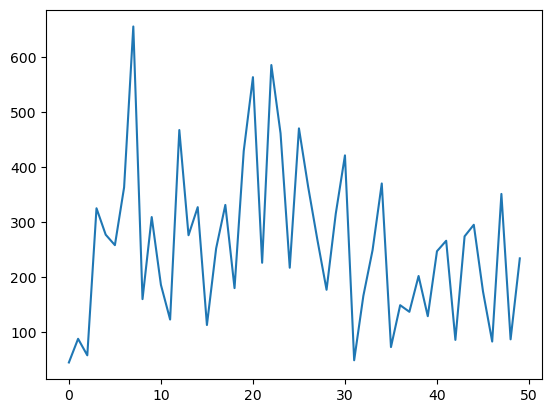

In [36]:
plt.plot(survive_time_player_1)
plt.savefig(f'./model/survive_time_player_1_{d}_episode{num_episodes}')
plt.show()

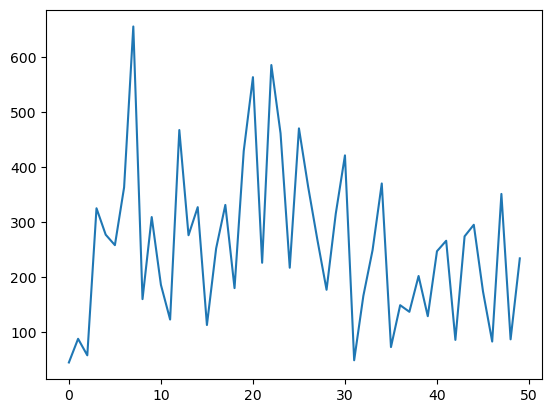

In [37]:
plt.plot(survive_time_player_4)
plt.savefig(f'./model/survive_time_player_4_{d}_episode{num_episodes}')
plt.show()

In [38]:
reward_every_round_player_1 = [i.cpu() for i in reward_every_round_player_1]
reward_every_round_player_4 = [i.cpu() for i in reward_every_round_player_4]

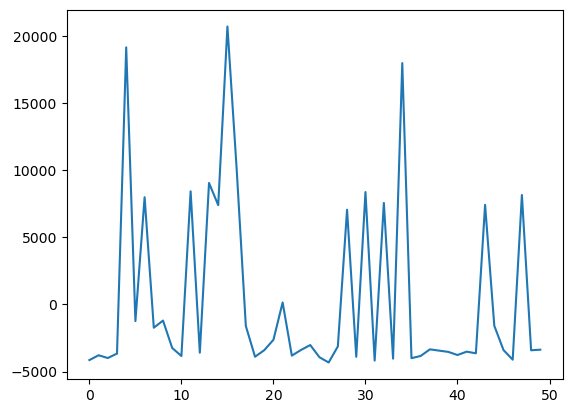

In [39]:
plt.plot(reward_every_round_player_1)
plt.savefig(f'./model/reward_player_1_{d}_episode{num_episodes}')
plt.show()

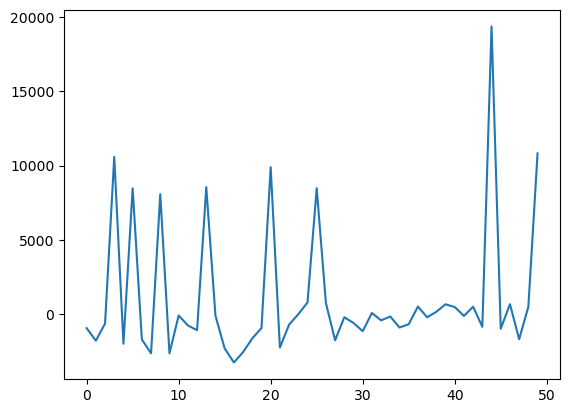

In [40]:
plt.plot(reward_every_round_player_4)
plt.savefig(f'./model/reward_player_4_{d}_episode{num_episodes}')
plt.show()

In [41]:
#plt.plot(win_memorize)
#plt.savefig(f'./model/reward_{d}_episode{num_episodes}')
#plt.show()

In [42]:
torch.save(policy_net.state_dict(), f'./model/{d}_policy_net_state_dic_episode{num_episodes}')
torch.save(target_net.state_dict(), f'./model/{d}_target_net_state_dic_episode{num_episodes}')

In [43]:
torch.save(policy_net, f'./model/{d}_policy_net_episode{num_episodes}')
torch.save(target_net, f'./model/{d}_target_net_episode{num_episodes}')
torch.save(policy_net2, f'./model/{d}_policy_net2_episode{num_episodes}')
torch.save(target_net2, f'./model/{d}_target_net2_episode{num_episodes}')